In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
# -------------------------------------------------
# Matplotlib settings for thicker lines & bigger fonts
# -------------------------------------------------
plt.rcParams.update({
    'font.size': 18,          # Default text size
    'axes.labelsize': 18,     # Axis label size
    'axes.titlesize': 20,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'lines.linewidth': 2,     # Thicker lines by default
    'lines.markersize': 9,
    'axes.linewidth': 2,
    'xtick.major.size': 10,
    'xtick.major.width': 2,
    'ytick.major.size': 10,
    'ytick.major.width': 2,
    'xtick.minor.size': 5,
    'xtick.minor.width': 1,
    'ytick.minor.size': 5,
    'ytick.minor.width': 1
})


# Second Sound | Superfluid Helium 

## Loading and inspecting the data


First we define a custom function to load the data and we plot the data to make sure we understand its structure and identify the important signals

In [10]:
def get_data(pressure, directory="../Data/SecondSound"):

    filenames = f"{pressure}mtorr*.csv"
    files = glob.glob(os.path.join(directory, filenames))

    dataframes = {}

    for file in files:
        # Step 1: Figure out how many lines to skip to reach the data
        with open(file, 'r') as f:
            lines = f.readlines()

        # Find the header row (the row that starts with "TIME,CH1,...")
        header_line = None
        for idx, line in enumerate(lines):
            if line.strip().startswith("TIME,CH1,CH2,CH3,CH4"):
                header_line = idx
                break

        if header_line is None:
            raise ValueError(f"No data header found in {file}")

        # Step 2: Read the file into a DataFrame, starting at the detected header
        df = pd.read_csv(file, skiprows=header_line, delimiter=",")
        
        # Optional: Store the dataframe in a dictionary with the filename as key
        dataframes[os.path.basename(file)] = df

    return dataframes


In [11]:
dataframes = get_data(20.0)

In [12]:
df = dataframes['20.0mtorr_109.5mm.csv']
df

,TIME,CH1,CH2,CH3,CH4
0,-0.001430,-0.001250,-0.040625,0.243750,-0.001241
1,-0.001429,-0.026875,0.021875,0.168750,-0.001271
2,-0.001428,-0.015625,-0.027344,0.170312,-0.001431
3,-0.001427,-0.001563,-0.003125,0.343750,-0.001286
4,-0.001426,0.013437,-0.029687,0.342187,-0.001541
...,...,...,...,...,...
9995,0.008565,5.003750,-0.053125,0.142188,-0.001857
9996,0.008566,5.023440,0.085156,0.243750,-0.001667
9997,0.008567,5.033750,-0.015625,0.243750,-0.001572
9998,0.008568,5.033750,-0.039844,0.195312,-0.001576


The input signal corresponds to CH3 and the bolometer signal corresponds to CH4

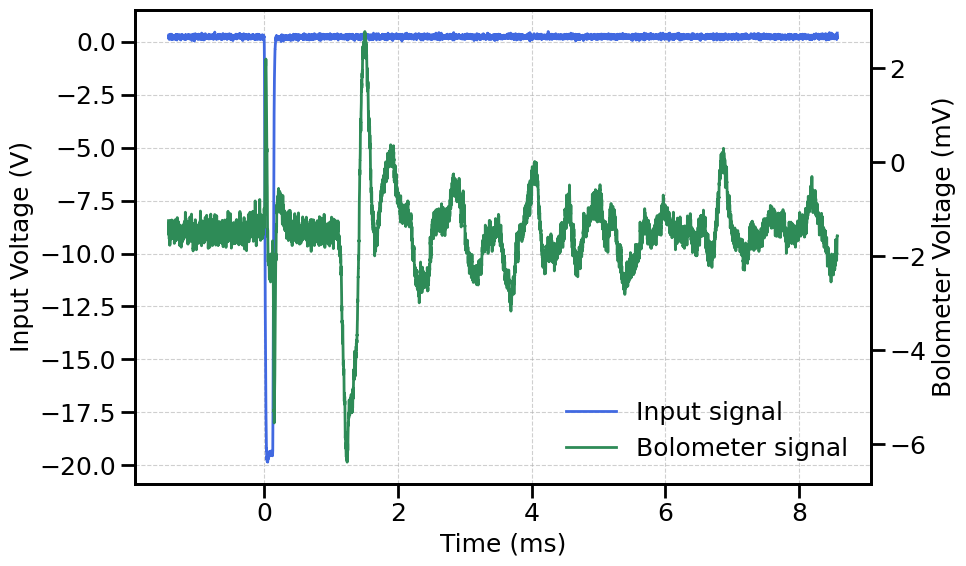

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot CH3 on the left y-axis (input signal)
ax1.plot(df["TIME"]*1000, df["CH3"], color='royalblue', label="Input signal", linewidth=2)
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Input Voltage (V)", color='black')
ax1.tick_params(axis='y', colors='black')  # Keep left ticks black
ax1.tick_params(axis='x', colors='black')  # Keep x-axis ticks black
ax1.grid(True, linestyle='--', alpha=0.6)

# Create the second y-axis (right side)
ax2 = ax1.twinx()

# Plot CH4 on the right y-axis (bolometer signal)
ax2.plot(df["TIME"]*1000, df["CH4"]*1000, color='seagreen', label="Bolometer signal", linewidth=2)
ax2.set_ylabel("Bolometer Voltage (mV)", color='black')
ax2.tick_params(axis='y', colors='black')  # Keep right ticks black

# Optional: Add a combined legend (you need to gather handles from both axes)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best', frameon=False)

plt.tight_layout()
plt.show()


/Users/jorgegarciaponce/Desktop/Classes/Senior Spring/Physics 191/Superfluid Helium/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jorgegarciaponce/Desktop/Classes/Senior Spring/Physics 191/Superfluid Helium/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


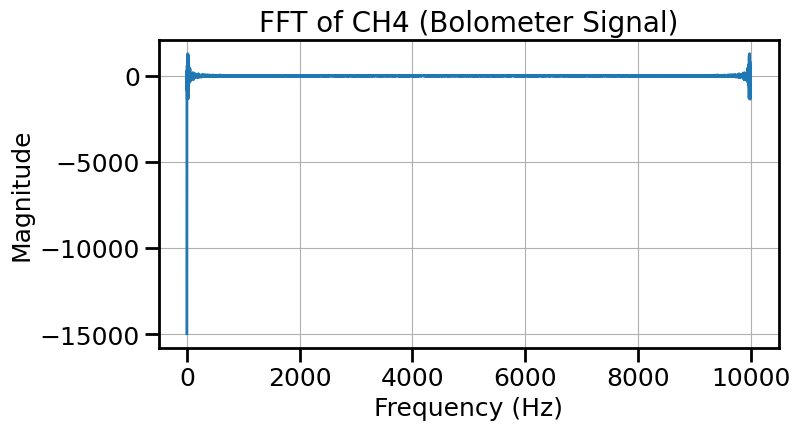

In [33]:

time = df["TIME"].values*1000          # Time array (in miliseconds)
ch4_signal = df["CH4"].values*1000     # CH4 signal array (in milivolts)

# Calculate the time step (sampling interval)
dt = np.mean(np.diff(time))  # dt in miliseconds

# Compute the FFT of the CH4 signal
fft_values = np.fft.fft(ch4_signal)

# Generate frequency bins corresponding to the FFT values
N = len(ch4_signal)
freqs = np.fft.fftfreq(N, d=dt/1000)


# Plot the magnitude spectrum
plt.figure(figsize=(8, 4))
plt.plot(fft_values)
# plt.plot(positive_freqs, np.abs(positive_fft), color='seagreen')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of CH4 (Bolometer Signal)')
plt.grid(True)
# plt.xlim(-10,1000000)
plt.show()

In [22]:
time

array([-1.43 , -1.429, -1.428, ...,  8.567,  8.568,  8.569],
      shape=(10000,))

we define a helper function to sort the data files in ascending order with respect to the distance

In [34]:
# Simple function to get the float value from the filename
def get_distance(key):
    return float(key.split('_')[1].replace('mm.csv', ''))

In [35]:

# Sort using the simple function
sorted_keys = sorted(dataframes.keys(), key=get_distance)
sorted_keys

['20.0mtorr_109.5mm.csv',
 '20.0mtorr_120.5mm.csv',
 '20.0mtorr_130.5mm.csv',
 '20.0mtorr_140.0mm.csv',
 '20.0mtorr_150.0mm.csv']

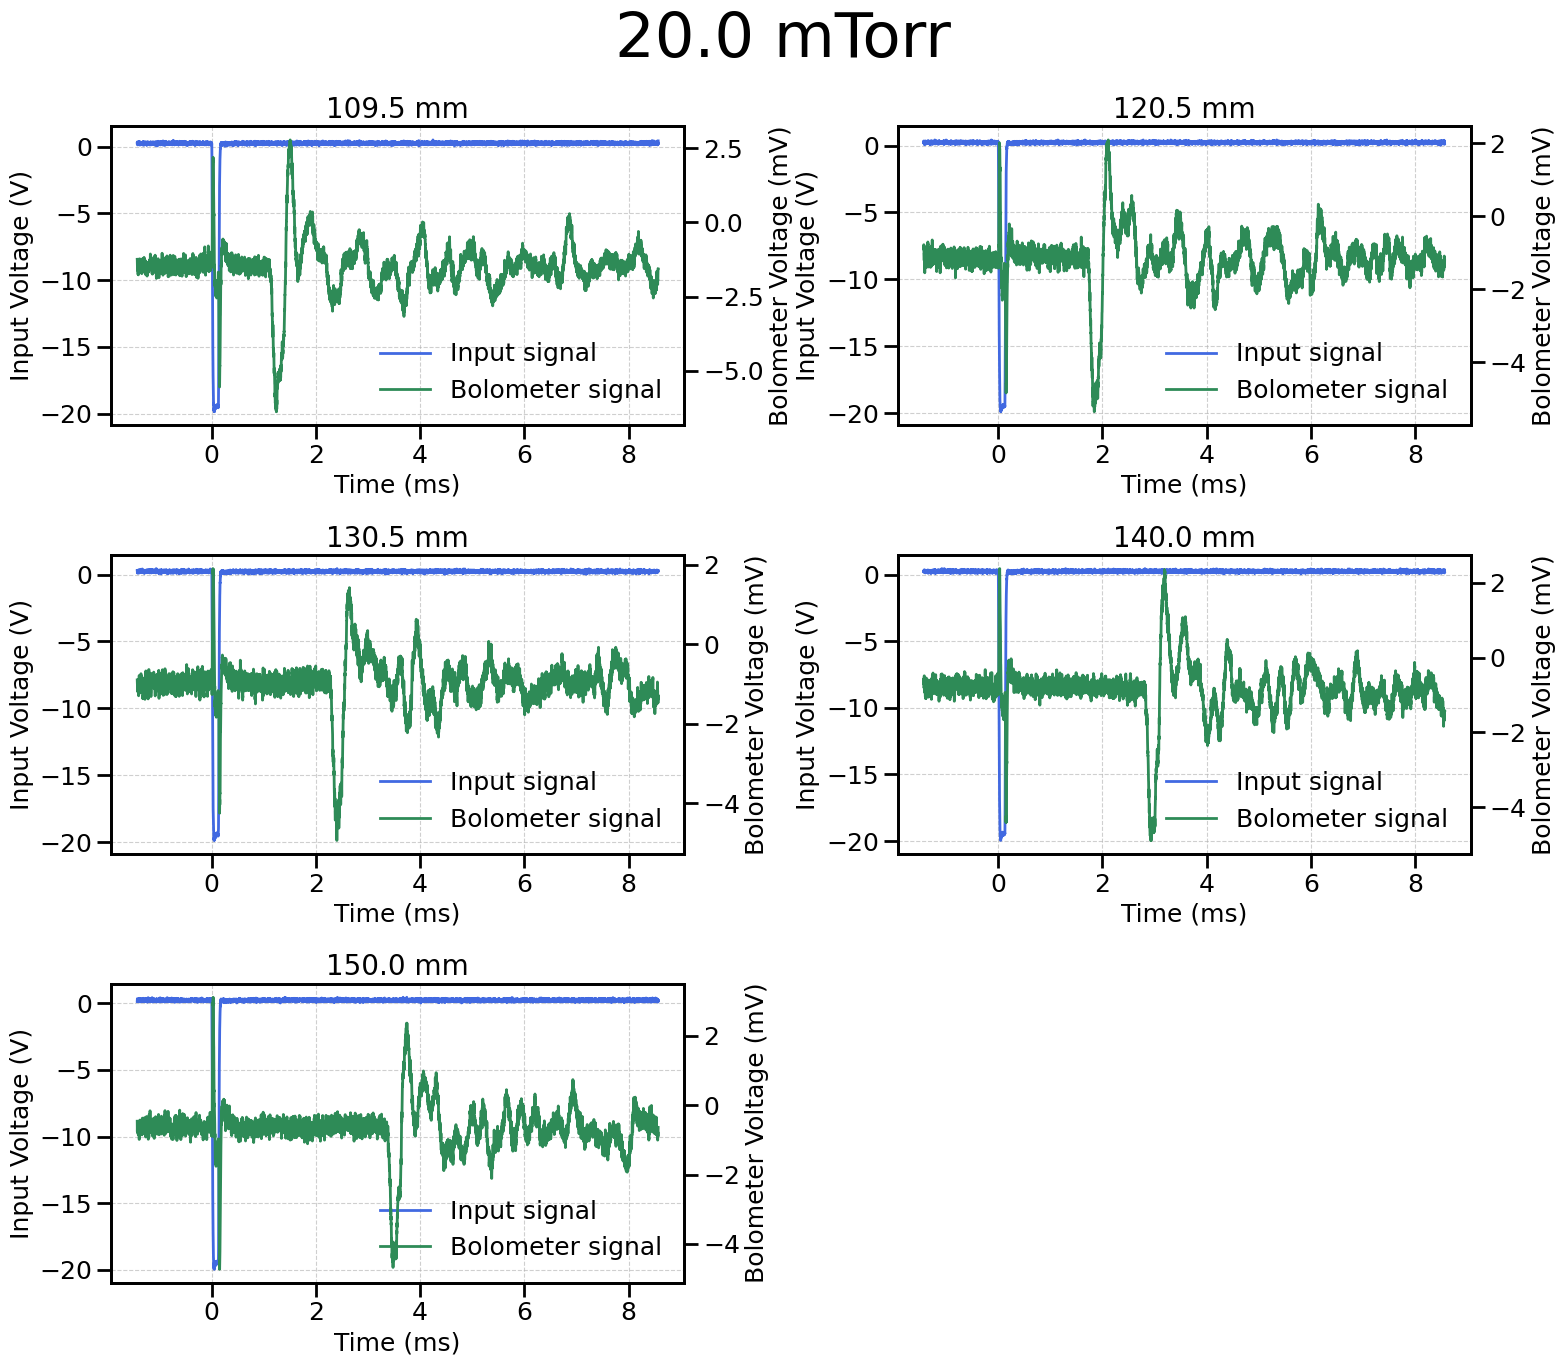

In [36]:
sorted_keys = sorted(dataframes.keys(), key=get_distance)
sorted_keys

dfs = [dataframes[key] for key in sorted_keys]

# Create the 3x2 grid layout (3 plots on top, 2 on bottom)
fig, axes = plt.subplots(3,2, figsize=(16, 14))

fig.suptitle("20.0 mTorr", fontsize=45)

axes = axes.flatten()

# Only plot on the first 5 axes
for i, (df, key) in enumerate(zip(dfs, sorted_keys)):
    ax1 = axes[i]

    ax1.set_title(key.split('_')[1].replace('mm.csv', ' mm'))
    
    # Plot CH3 on the left y-axis (input signal)
    ax1.plot(df["TIME"]*1000, df["CH3"], color='royalblue', label="Input signal", linewidth=2)
    ax1.set_xlabel("Time (ms)")
    ax1.set_ylabel("Input Voltage (V)", color='black')
    ax1.tick_params(axis='y', colors='black')
    ax1.tick_params(axis='x', colors='black')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Create twin axis for bolometer signal
    ax2 = ax1.twinx()
    ax2.plot(df["TIME"]*1000, df["CH4"]*1000, color='seagreen', label="Bolometer signal", linewidth=2)
    ax2.set_ylabel("Bolometer Voltage (mV)", color='black')
    ax2.tick_params(axis='y', colors='black')
    
    # Add legend (once per subplot)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='best', frameon=False)

# Hide any unused subplot (in case of 3x2 layout with only 5 plots)
for j in range(5, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.savefig("../Figures/SecondSound/data_collection.png", dpi=300)
plt.show()


yay! This is so nice.

Now we proceed with the analysis

## Analysis


In [37]:
temperature_scale = np.loadtxt("../Data/helium_temperature_scale.txt")
equilibrium_vapor_pressures = temperature_scale[:,0]
equilibrium_temperatures = temperature_scale[:,1]

In [38]:
def get_correlated_distance(measured_distance):

    bolometer_distance  = measured_distance - 109.5 + 22.5

    return bolometer_distance

In [39]:
def get_approximate_temperature(vapor_pressure):

    ind = np.abs(equilibrium_vapor_pressures - vapor_pressure*1000).argmin()

    return equilibrium_temperatures[ind]

We find the peaks of the bolometer signal. For that, we had to play around with the height and prominence parameter to isolate the right peak.

In [40]:
dataframes = get_data(20.0)

sorted_keys = sorted(dataframes.keys(), key=get_distance)
sorted_keys

dfs = [dataframes[key] for key in sorted_keys]

df = dfs[2]

In [41]:
def get_speed_data(pressure, plot=True):

    print(f"Collecting data for {pressure} mTorr")
    dataframes = get_data(pressure)

    sorted_keys = sorted(dataframes.keys(), key=get_distance)


    dfs = [dataframes[key] for key in sorted_keys]

    speed_data = []

    for (df, key) in zip(dfs, sorted_keys):

        measured_distance = float(key.split('_')[1].replace('mm.csv', ''))

        bolometer_distance = get_correlated_distance(measured_distance)

        bolometer_peaks, _ = find_peaks(-1 * df["CH4"] * 1000, height=1.5, prominence=1.7)

        # Find and print the time of the second peak (if there are at least two peaks)
        if len(bolometer_peaks) >= 2:
            second_peak_time = df["TIME"].iloc[bolometer_peaks[1]]
            print(f"Second peak time: {second_peak_time:.8f} s")
            speed_data.append(np.array([bolometer_distance, second_peak_time]))

        else:
            print(f"Less than 2 peaks found for {key}")


        if plot:

            plt.plot(df["TIME"], df["CH4"] * 1000, label='Signal')

            # print(bolometer_peaks)
            plt.plot(df["TIME"].iloc[bolometer_peaks], (df["CH4"] * 1000).iloc[bolometer_peaks], 'ro', label='Peaks')

            plt.title(bolometer_distance)
            plt.legend()
            plt.show()

    return np.array(speed_data)



Second peak time: 0.00124100 s


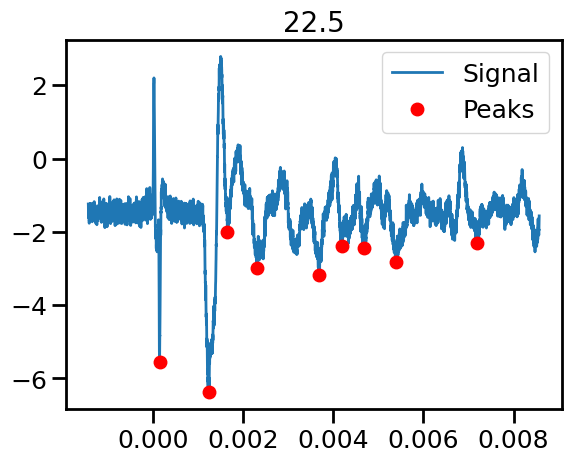

Second peak time: 0.00184400 s


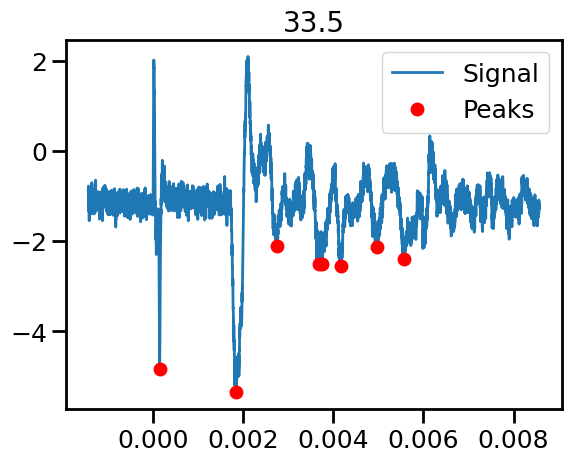

Second peak time: 0.00240200 s


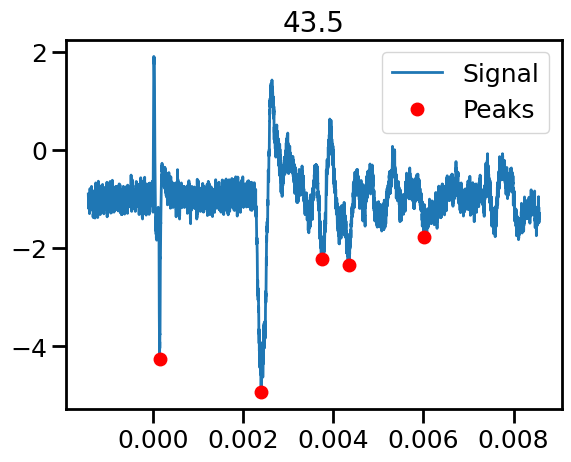

Second peak time: 0.00293500 s


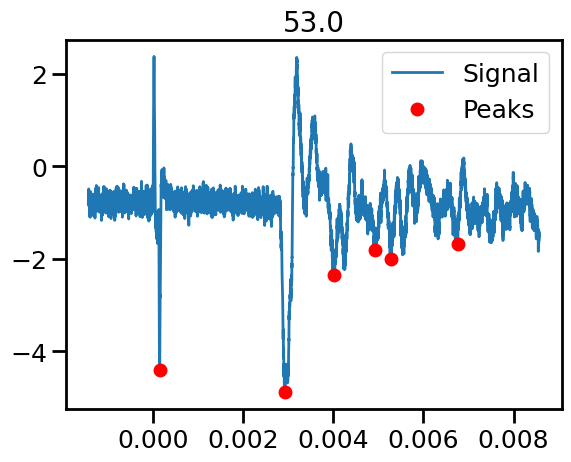

Second peak time: 0.00348000 s


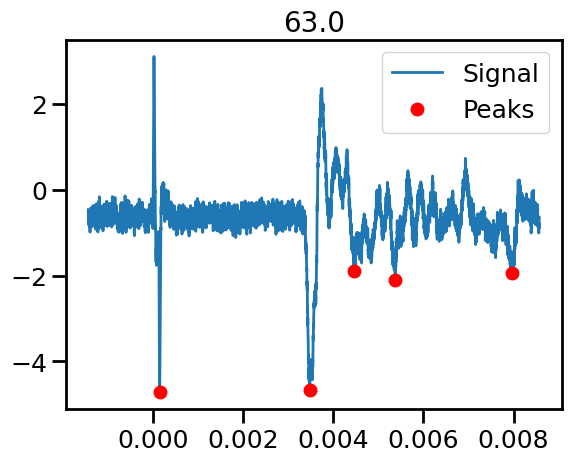

In [42]:
speed_data = get_speed_data(20.0, True)

In [43]:
pressures = np.array([20.0, 22.4, 25.0, 27.4, 30.0])

speed_data_all_pressures = []

for pressure in pressures:

    speed_data_all_pressures.append(get_speed_data(pressure=pressure, plot=False))

speed_data_all_pressures = np.array(speed_data_all_pressures)


Second peak time: 0.00124100 s
Second peak time: 0.00184400 s
Second peak time: 0.00240200 s
Second peak time: 0.00293500 s
Second peak time: 0.00348000 s
Second peak time: 0.00128800 s
Second peak time: 0.00188600 s
Second peak time: 0.00249900 s
Second peak time: 0.00304300 s
Second peak time: 0.00363100 s
Second peak time: 0.00150500 s
Second peak time: 0.00205300 s
Second peak time: 0.00264900 s
Second peak time: 0.00327300 s
Second peak time: 0.00383100 s
Second peak time: 0.00161200 s
Second peak time: 0.00220500 s
Second peak time: 0.00281800 s
Second peak time: 0.00350300 s
Second peak time: 0.00416300 s
Second peak time: 0.00160200 s
Second peak time: 0.00241600 s
Second peak time: 0.00313900 s
Second peak time: 0.00385800 s
Second peak time: 0.00508200 s


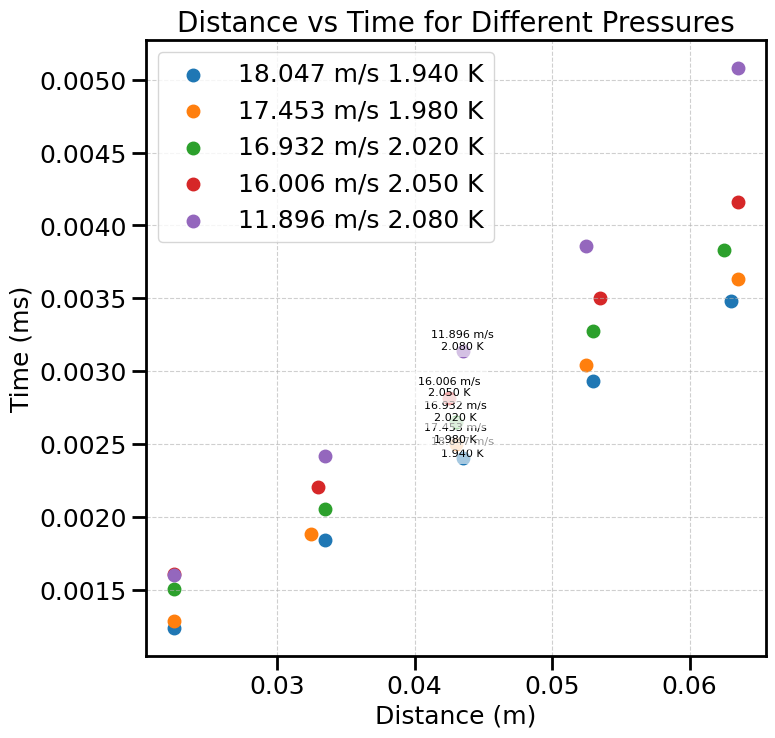

In [49]:
plt.figure(figsize=(8, 8))  # Optional: set figure size

speeds = []

for i, pressure in enumerate(pressures):
    distance = speed_data_all_pressures[i, :, 0]*1e-3  # distance in meters
    time = speed_data_all_pressures[i, :, 1]  # time in seconds

    # Linear fit: np.polyfit returns [slope, intercept]
    slope, intercept = np.polyfit(time, distance, 1)

    speeds.append(slope)
    
    plt.scatter(distance, time, label=f'{slope:.3f} m/s {get_approximate_temperature(pressure):.3f} K')  # Add pressure label to legend

    # Choose position for the text (midpoint of the line)
    mid_idx = len(time) // 2
    mid_x = distance[mid_idx]
    mid_y = time[mid_idx]

    # Annotate near the middle of each line
    plt.text(mid_x, mid_y, f'{slope:.3f} m/s\n{get_approximate_temperature(pressure):.3f} K',
             fontsize=8, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

        
plt.ylabel("Time (ms)")
plt.xlabel("Distance (m)")
plt.legend(title="")
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Distance vs Time for Different Pressures")
plt.show()


speeds = np.array(speeds)

In [45]:
def second_sound(x, tl):

    return (
        26 * np.sqrt(
            (x/tl) * (1 - (x/tl)**5.5)
        )
    )

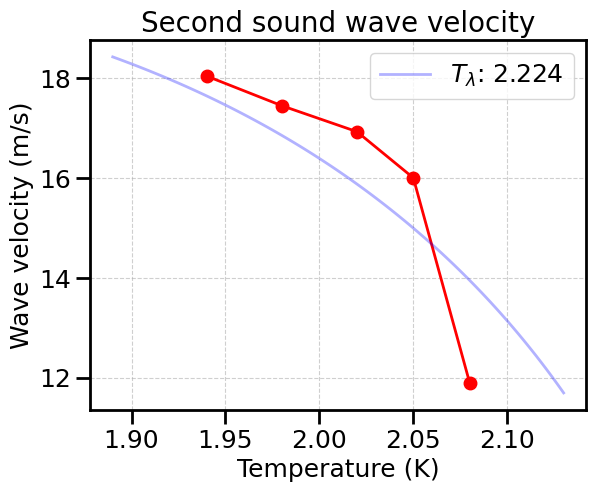

In [46]:
temperatures = [get_approximate_temperature(p) for p in pressures]

plt.plot(temperatures, speeds, '-o', color='red')


popt, pcov = curve_fit(second_sound, temperatures, speeds, p0=[2.17])

Tl_fit = popt[0]


x = np.linspace(temperatures[0]-0.05, temperatures[-1]+0.05, 100)

plt.plot(x, [second_sound(T, Tl_fit) for T in x], '-', color='blue', alpha=0.3, label=rf"$T_\lambda$: {Tl_fit:.3f}")



plt.xlabel("Temperature (K)")
plt.ylabel("Wave velocity (m/s)")
plt.legend(title="")
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Second sound wave velocity")
plt.show()


speeds = np.array(speeds)